In [1]:
import logging

logging.basicConfig(level=logging.INFO)


In [2]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss, MSELoss

# from pennylane import NesterovMomentumOptimizer

from qcc.ml.data import Data, BinaryData
from qcc.ml.optimize import Optimizer
from qcc.ml.data import ImageTransform, ImageTransform1D, ClassicalImageTransform
from qcc.experiment import Experiment
from qcc.ml.model import Model

from pathlib import Path
from qcc.file import new_dir

from qcc.quantum.pennylane.ansatz import MQCCOptimized as Module
# from qcc.ml.cnn import ConvolutionalNeuralNetwork as Module
# from qcc.ml.hybrid_cnn import MQCCHybrid as Module

# from qcc.quantum.pennylane.ansatz.basic import BasicFiltering6
from qcc.quantum.pennylane.pyramid import Pyramid
from qcc.quantum.pennylane.c2q import ConvolutionAngleFilter, ConvolutionComplexAngleFilter, ConvolutionFilter
from qcc.quantum.pennylane.local import define_filter


In [3]:
# Meta parameters
name = "sdfljhvosdv"
filename = Path(f"results/{name}")
num_trials = 1
silent = False
is_quantum = True

# Ansatz parameters
dims = (16, 16)
num_layers = 3
module_options = {
    "U_filter": ConvolutionAngleFilter,
    "pre_op": True,
    # "num_features": 4,
    # "U_fully_connected": ConvolutionAngleFilter,
    # "pooling": True,
    # # "filter_shape": (2, 2, 2),
    # "q2c_method": "parity"
    # "bias": True
}


INFO:qcc.quantum.pennylane.ansatz.ansatz:Depth: 22
INFO:qcc.quantum.pennylane.ansatz.ansatz:Gate Count: 84
2023-10-25 18:47:46,394: (mqccoptimized) Circuit ID: sdfljhvosdv
2023-10-25 18:47:46,394: (mqccoptimized) module=MQCCOptimized()
2023-10-25 18:47:46,395: (mqccoptimized) data=BinaryData(dataset=<class 'torchvision.datasets.mnist.FashionMNIST'>, transform=image_transform, target_transform=None, batch_size=(8, 8), classes=[0, 1])
2023-10-25 18:47:46,395: (mqccoptimized) optimizer=<class 'torch.optim.adam.Adam'>, self.args=(), self.kwargs={}
2023-10-25 18:47:46,395: (mqccoptimized) loss=CrossEntropyLoss()
2023-10-25 18:47:46,395: (mqccoptimized) num_trials=1
2023-10-25 18:47:46,395: (mqccoptimized) dims=(16, 16)
2023-10-25 18:47:46,395: (mqccoptimized) num_layers=3
2023-10-25 18:47:46,396: (mqccoptimized) module_options={'U_filter': <class 'qcc.quantum.pennylane.c2q.ConvolutionAngleFilter'>, 'pre_op': True}


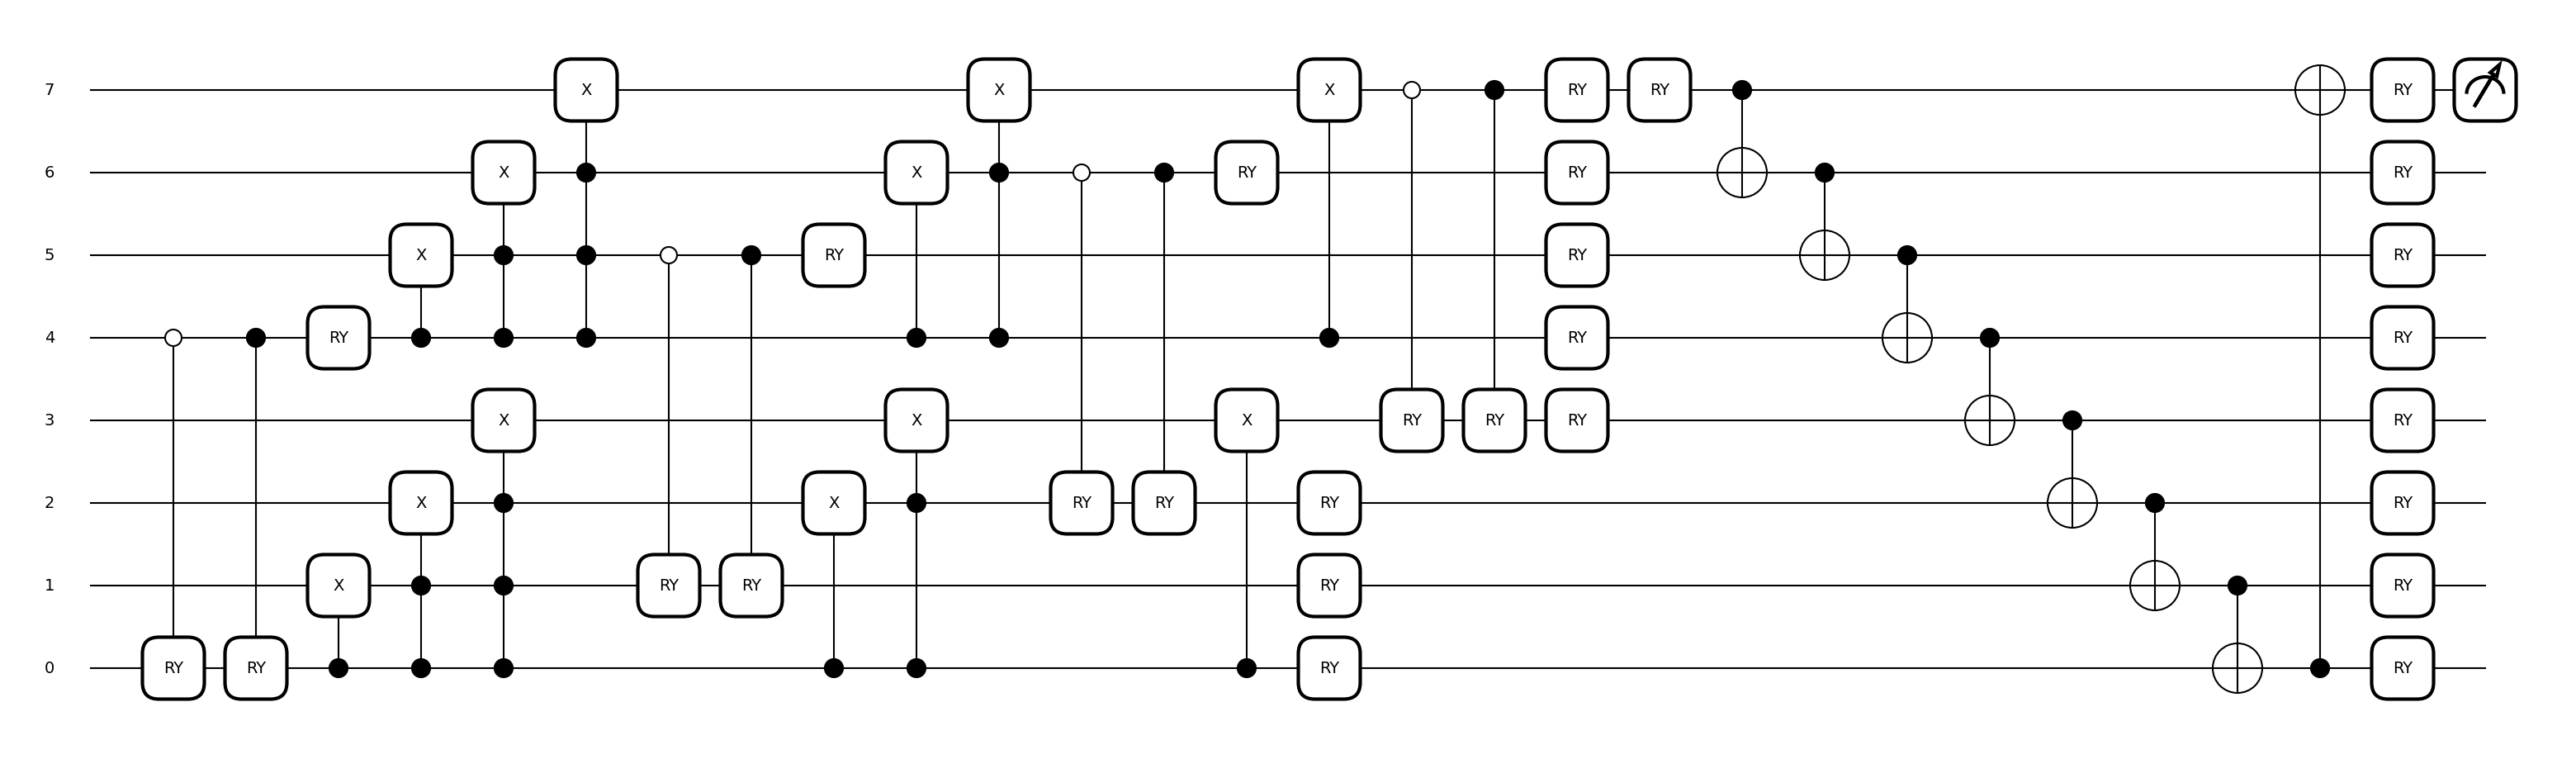

In [4]:
filename = new_dir(filename, overwrite=True)
filename = filename / name

if is_quantum:
    module = Module.from_dims
else:
    module = Module

# Create module
module = module(
    dims,
    num_layers=num_layers,
    **module_options,
)
data = BinaryData(
    FashionMNIST,
    ImageTransform(dims) if is_quantum else ClassicalImageTransform(dims),
    batch_size=(8,8),
)
optimizer = Optimizer(Adam)
loss = CrossEntropyLoss()
model = Model.with_logging(module, data, optimizer, loss, epoch=8)

# Log important values
model.logger.info(f"Circuit ID: {name}")
model.logger.info(f"{module=}")
model.logger.info(f"{data=}")
model.logger.info(f"{optimizer=}")
model.logger.info(f"{loss=}")

model.logger.info(f"{num_trials=}")
model.logger.info(f"{dims=}")
model.logger.info(f"{num_layers=}")
# model.logger.info(f"{1=}")
model.logger.info(f"{module_options=}")

# Save circuit drawing
if is_quantum:
    filename = filename.with_stem(f"{name}_circuit")
    module.draw(filename=filename, decompose=True)


In [5]:
# Run experiment
results_schema = ["accuracy", "training_time", "testing_time"]
experiment = Experiment(model, num_trials, results_schema)
# experiment.partial(silent=silent)
results = experiment(filename=filename)


2023-10-25 18:47:46,940: (mqccoptimized) Number of Parameters: 28
2023-10-25 18:48:18,394: (mqccoptimized) (Epoch 1) Training took 31.28441 sec
2023-10-25 18:48:21,796: (mqccoptimized) (Epoch 1) Testing took: 3.39841 sec
2023-10-25 18:48:21,797: (mqccoptimized) (Epoch 1) Accuracy: 90.600%
2023-10-25 18:48:53,062: (mqccoptimized) (Epoch 2) Training took 62.48765 sec
2023-10-25 18:48:56,462: (mqccoptimized) (Epoch 2) Testing took: 3.39788 sec
2023-10-25 18:48:56,462: (mqccoptimized) (Epoch 2) Accuracy: 91.350%


KeyboardInterrupt: 

In [ ]:
# Print accuracy results
metrics = ("median", "mean", "max", "min", "std")
for name in results.columns:
    col = results[name]
    msg = (f"{metric}={getattr(col, metric)()}" for metric in metrics)
    msg = ", ".join(msg)
    msg = f"{name}: {msg}"
    model.logger.info(msg)

# Save aggregated loss history figure
display(experiment.draw(filename))
